In [1]:
from endless_line.data_utils.dataloader import DataLoader

In [ ]:
data = DataLoader(data_dir_path="data", load_all_files=True)
data.clean_data()
data.data_preprocessing()
data.merge()


/Users/kiran/Hackathon-ElevenStrategy/endless_line/data_utils/dataloader.py:253: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.parade_night_show_attendance["Num_parade"] = 3 - self.parade_night_show_attendance[["NIGHT_SHOW",	"PARADE_1",	"PARADE_2"]].isna().sum(axis=1)


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf

# Mapping for ENTITY_DESCRIPTION_SHORT
entity_mapping = {
    'Rapids Ride': 1, 'Oz Theatre': 2, 'Spiral Slide': 3, 'Himalaya Ride': 4, 'Free Fall': 5,
    'Water Ride': 6, 'Merry Go Round': 7, 'Spinning Coaster': 8, 'Go-Karts': 9, 'Bumper Cars': 10,
    'Kiddie Coaster': 11, 'Bungee Jump': 12, 'Roller Coaster': 13, 'Flying Coaster': 14,
    'Haunted House': 15, 'Giga Coaster': 16, 'Crazy Dance': 17, 'Inverted Coaster': 18,
    'Drop Tower': 19, 'Circus Train': 20, 'Zipline': 21, 'Giant Wheel': 22, 'Swing Ride': 23,
    'Dizzy Dropper': 24, 'Superman Ride': 25
}

# Map ENTITY_DESCRIPTION_SHORT to numeric values
data.merged["ENTITY_DESCRIPTION_SHORT"] = data.merged["ENTITY_DESCRIPTION_SHORT"].map(entity_mapping)

# Identify columns to scale
columns_to_scale = [
    'NB_UNITS', 'GUEST_CARRIED', 'CAPACITY', 'ADJUST_CAPACITY','UP_TIME', 'DOWNTIME', 'NB_MAX_UNIT', 'Num_parade', 'temp', 
    'feels_like', 'pressure', 'wind_speed', 'clouds_all', 'attendance'
]

# Scale features to [0, 1] range
scaler = MinMaxScaler()
data.merged[columns_to_scale] = scaler.fit_transform(data.merged[columns_to_scale])

# Ensure DEB_TIME is a datetime column

data.merged['DEB_TIME'] = pd.to_datetime(data.merged['DEB_TIME'])

# Set DEB_TIME as the index and sort by it
data.merged = data.merged.sort_values('DEB_TIME').set_index('DEB_TIME')
# Drop rows with NaN values
data.merged = data.merged.dropna()

# Ensure WORK_DATE is a datetime object
data.merged["WORK_DATE"] = pd.to_datetime(data.merged["WORK_DATE"], errors="coerce")
data.merged = data.merged.drop(columns=["FIN_TIME"])
# Define date ranges
train_start_date = "2020-06-01"  # Define your train start date
train_end_date = "2021-11-30"    # Define your train end date
test_start_date = "2021-12-01"   # Define your test start date
test_end_date = "2021-12-20"     # Define your test end date
predict_start_date = "2021-12-23"  # Define your prediction start date for model comparison
predict_end_date = "2021-12-30"    # Define your prediction end date

# Extract features (X) and target (y)
target = 'WAIT_TIME_MAX'
X = data.merged.drop(columns=["WAIT_TIME_MAX"])   # Drop the target column
y = data.merged[target]


train_data = data.merged[(data.merged["WORK_DATE"] >= train_start_date) & (data.merged["WORK_DATE"] <= train_end_date)]
test_data = data.merged[(data.merged["WORK_DATE"] >= test_start_date) & (data.merged["WORK_DATE"] <= test_end_date)]
predict_data = data.merged[data.merged["WORK_DATE"] >= predict_start_date ]


# Separate features (X) and target (y) for train and test
target = "WAIT_TIME_MAX"
non_numeric_columns = ["WORK_DATE"]  # Columns to keep for later analysis
X_train = train_data.drop(columns=[target] + non_numeric_columns).values
y_train = train_data[target].values
X_test = test_data.drop(columns=[target] + non_numeric_columns).values
y_test = test_data[target].values

timesteps = 1  # Each sample contains one timestep
X_train_reshaped = X_train.reshape(X_train.shape[0], timesteps, X_train.shape[1])
X_test_reshaped = X_test.reshape(X_test.shape[0], timesteps, X_test.shape[1])




In [26]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from scikeras.wrappers import KerasRegressor
import matplotlib.pyplot as plt

In [ ]:
#Build LSTM model
model = Sequential([
    LSTM(64, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2]), return_sequences=True),
    Dropout(0.2),
    LSTM(32, return_sequences=False),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1)  # Single output for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
model.fit(X_train_reshaped, y_train, epochs=50, batch_size=32, validation_data=(X_test_reshaped, y_test))

# Evaluate the model
loss, mae = model.evaluate(X_test_reshaped, y_test)
print(f"Test Loss: {loss}, Test MAE: {mae}")

Epoch 1/50
23961/23961 ━━━━━━━━━━━━━━━━━━━━ 23s 921us/step - loss: 279.1894 - mae: 10.1445 - val_loss: 121.9505 - val_mae: 6.3173
Epoch 2/50
23961/23961 ━━━━━━━━━━━━━━━━━━━━ 22s 923us/step - loss: 133.9838 - mae: 6.6754 - val_loss: 93.7911 - val_mae: 5.6815
Epoch 3/50
23961/23961 ━━━━━━━━━━━━━━━━━━━━ 22s 919us/step - loss: 117.8382 - mae: 6.1339 - val_loss: 90.4755 - val_mae: 5.3640
Epoch 4/50
23961/23961 ━━━━━━━━━━━━━━━━━━━━ 22s 923us/step - loss: 109.0477 - mae: 5.8288 - val_loss: 83.3293 - val_mae: 5.2838
Epoch 5/50
23961/23961 ━━━━━━━━━━━━━━━━━━━━ 23s 949us/step - loss: 103.7910 - mae: 5.6670 - val_loss: 92.4273 - val_mae: 5.2883
Epoch 6/50
23961/23961 ━━━━━━━━━━━━━━━━━━━━ 23s 968us/step - loss: 102.3275 - mae: 5.5893 - val_loss: 80.9732 - val_mae: 4.9445
Epoch 7/50
23961/23961 ━━━━━━━━━━━━━━━━━━━━ 22s 936us/step - loss: 99.1271 - mae: 5.4924 - val_loss: 78.5495 - val_mae: 4.9630
Epoch 8/50
23961/23961 ━━━━━━━━━━━━━━━━━━━━ 23s 965us/step - loss: 98.2375 - mae: 5.4298 - val_loss: 86

875/875 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step


            Actual_Wait_Time  Predicted_Wait_Time
Attraction                                       
1                         50            32.354740
2                         15             7.555254
3                        135            94.234940
4                          5             6.569211
5                        120            89.050629
6                         60            37.971794
7                         50            40.439667
8                        110            61.996593
9                         90            64.349213
10                        30            18.378040
11                        15             9.287893
12                        65            35.847275
13                        60            25.745010
14                        45            38.731693
15                        45            21.333904
16                        60            31.510118
17                        10             6.109840
18                         0             1.091968


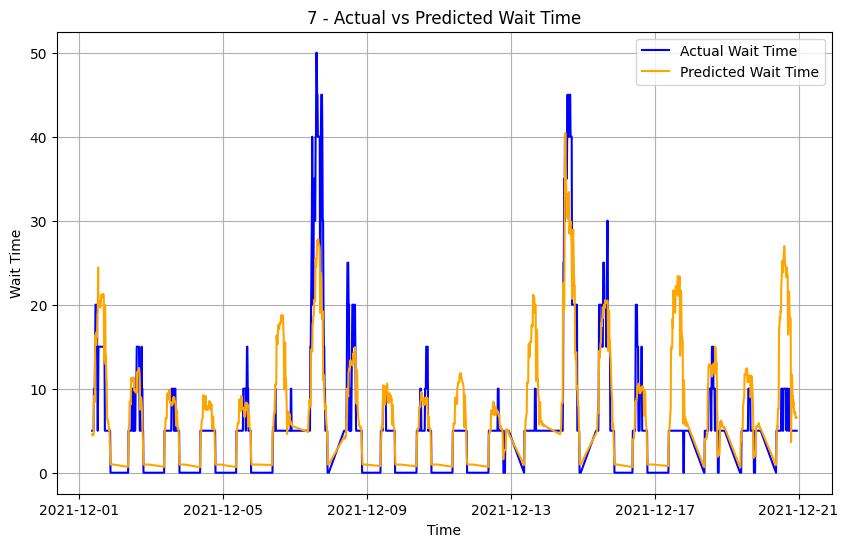

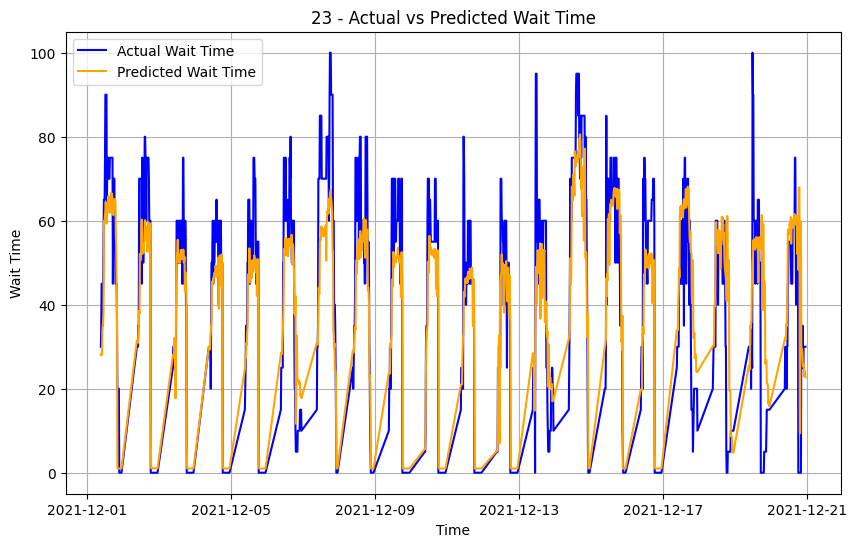

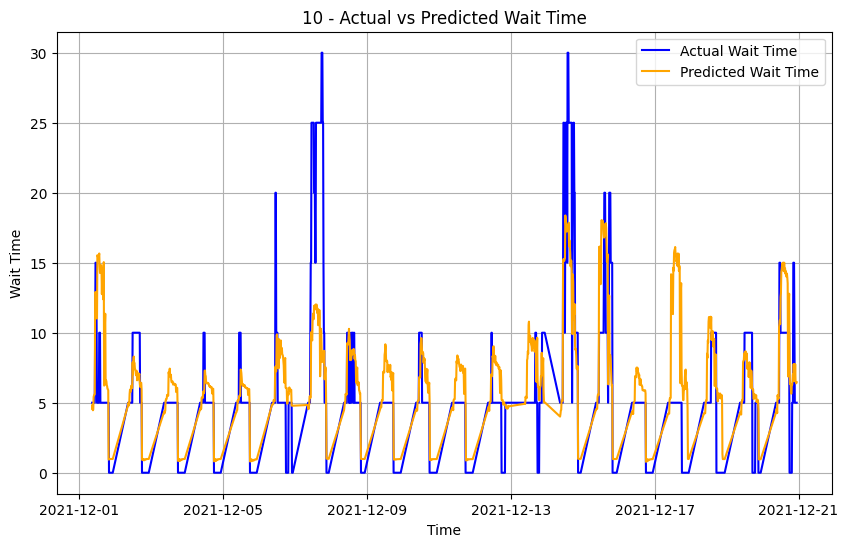

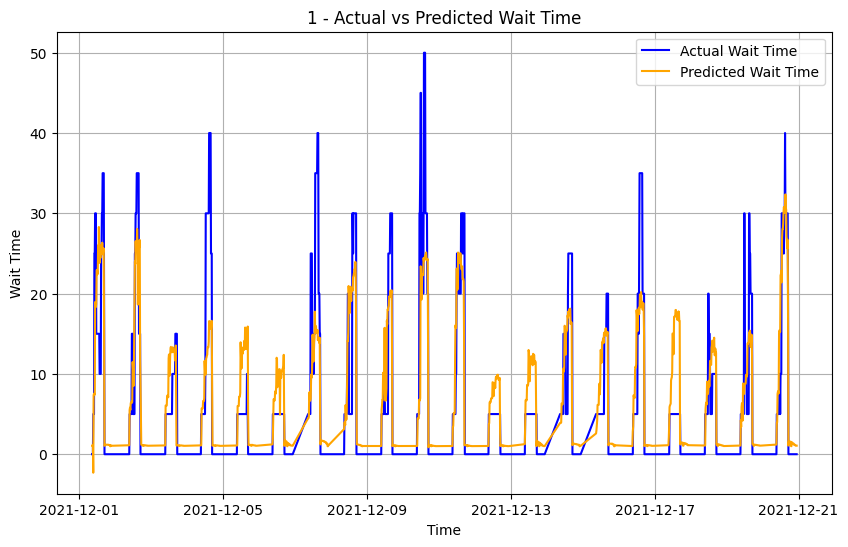

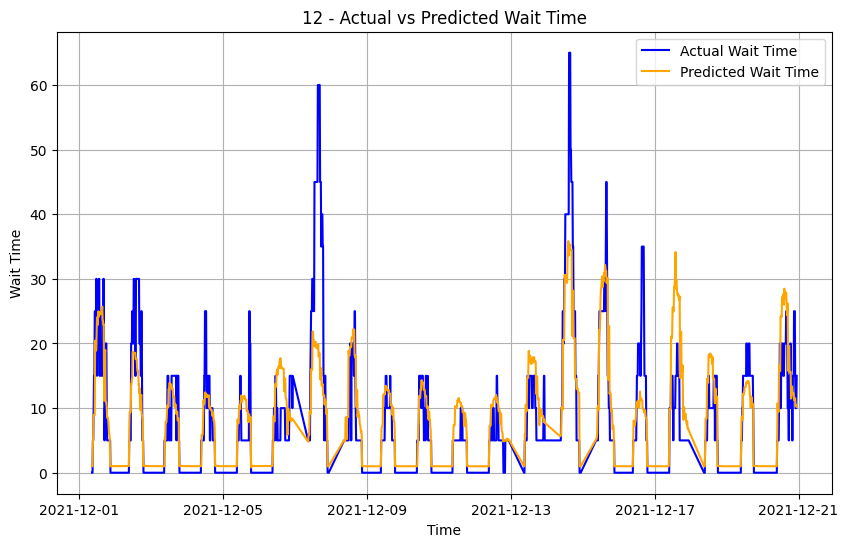

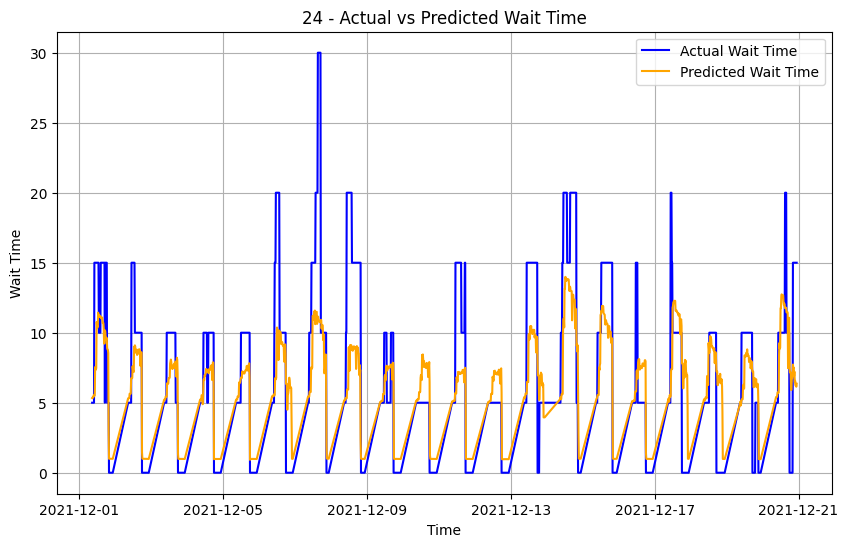

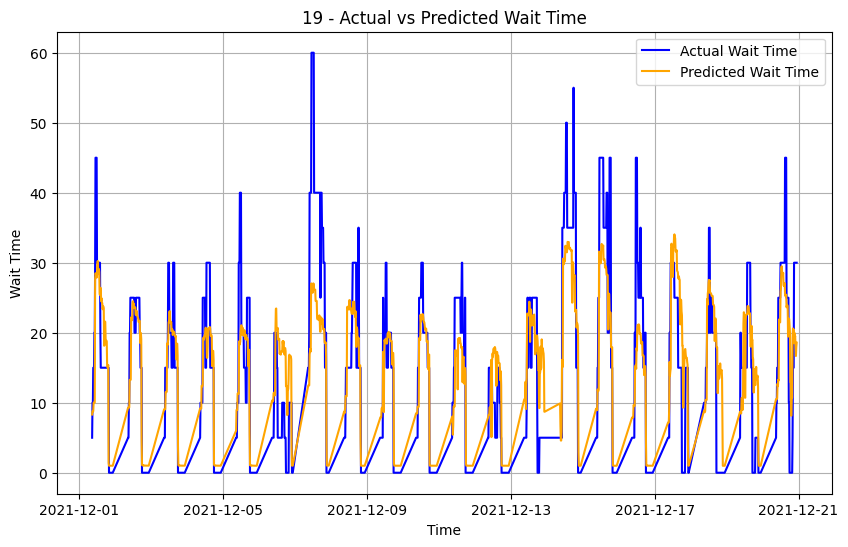

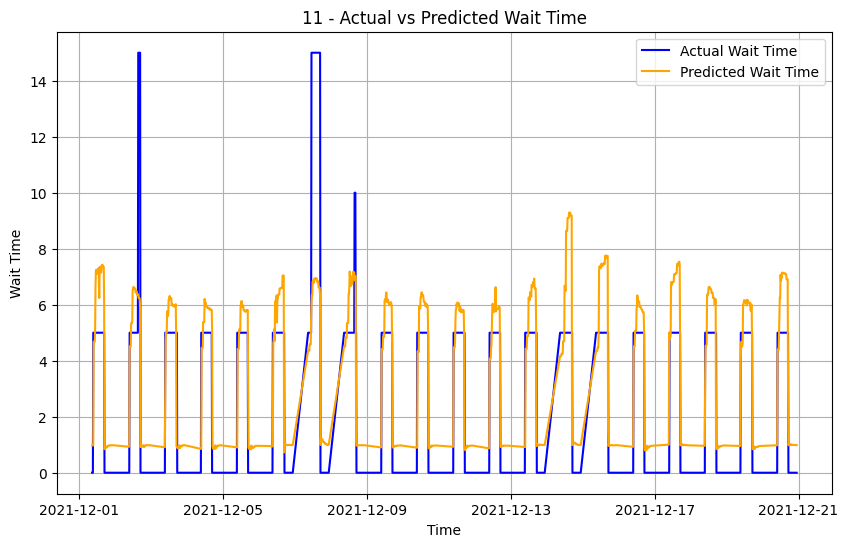

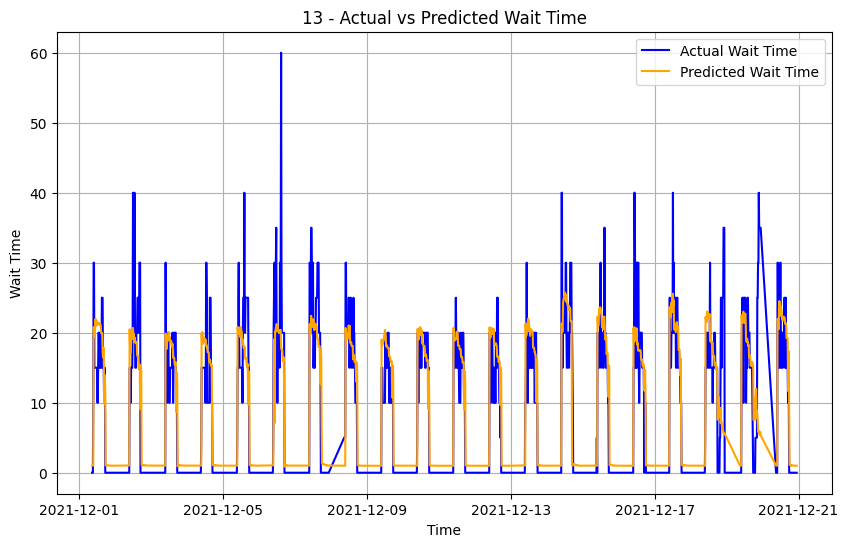

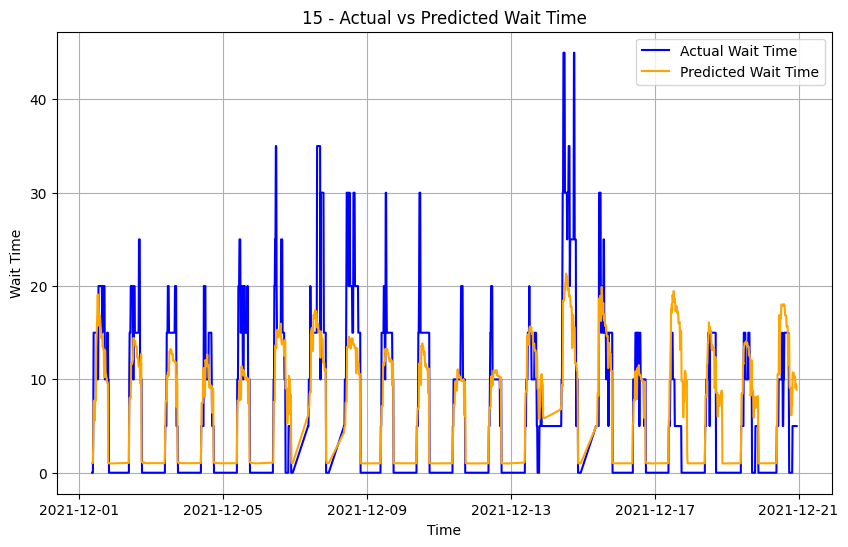

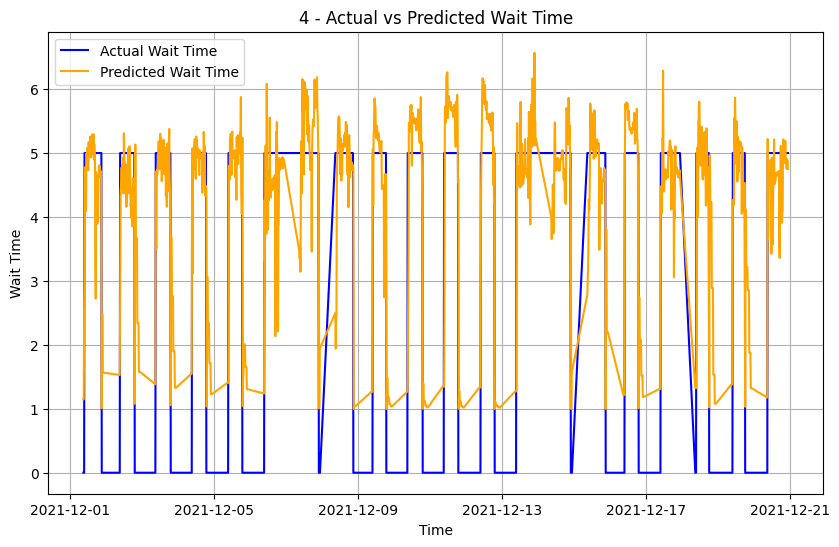

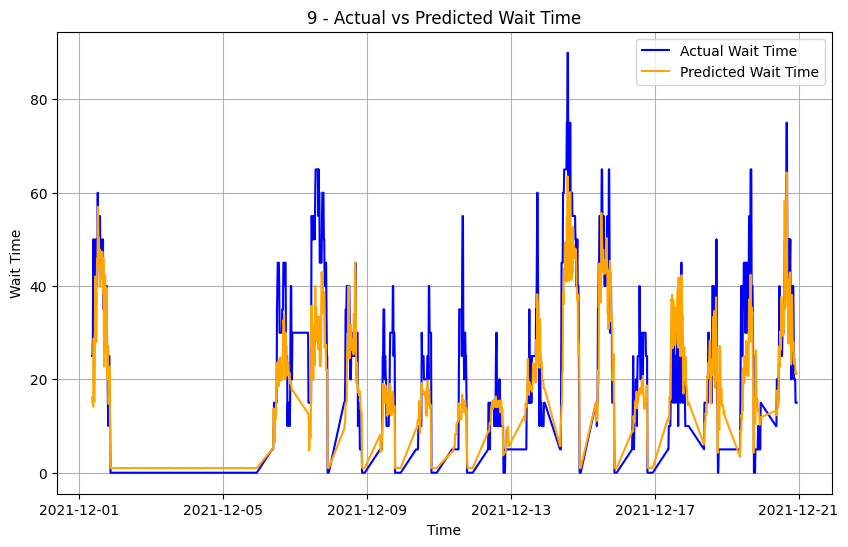

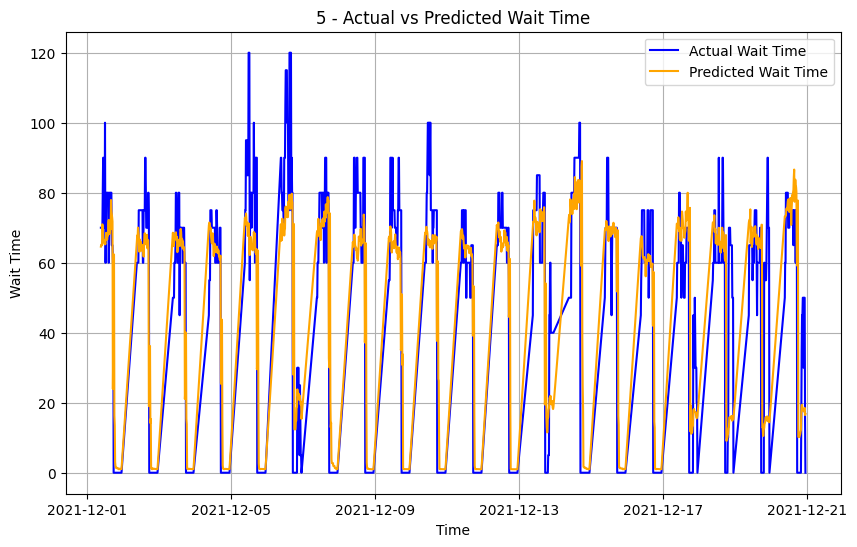

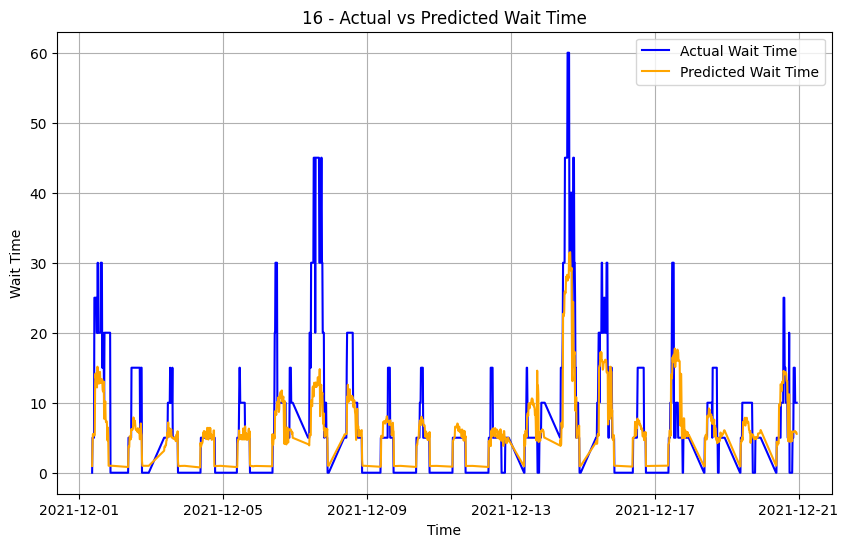

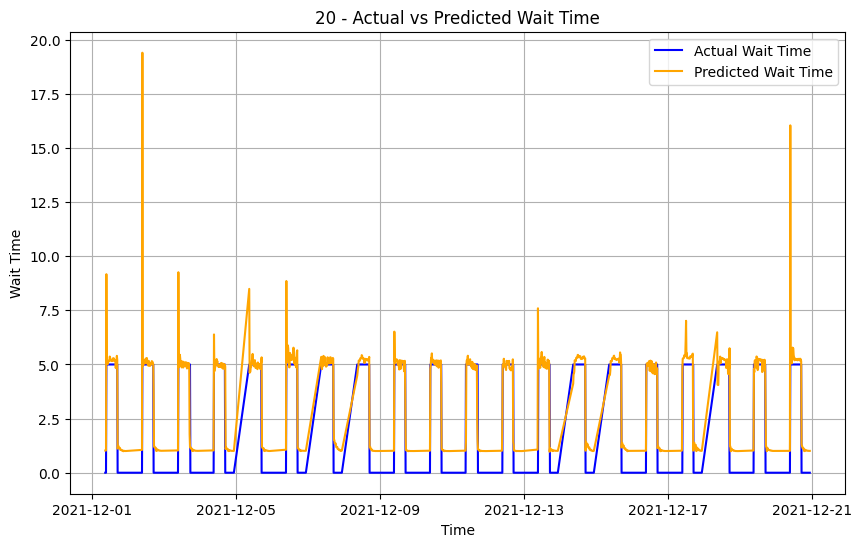

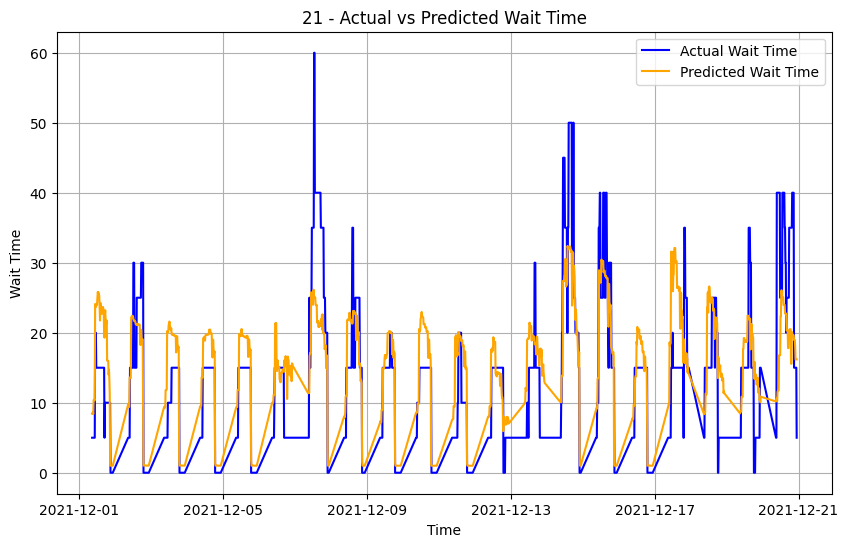

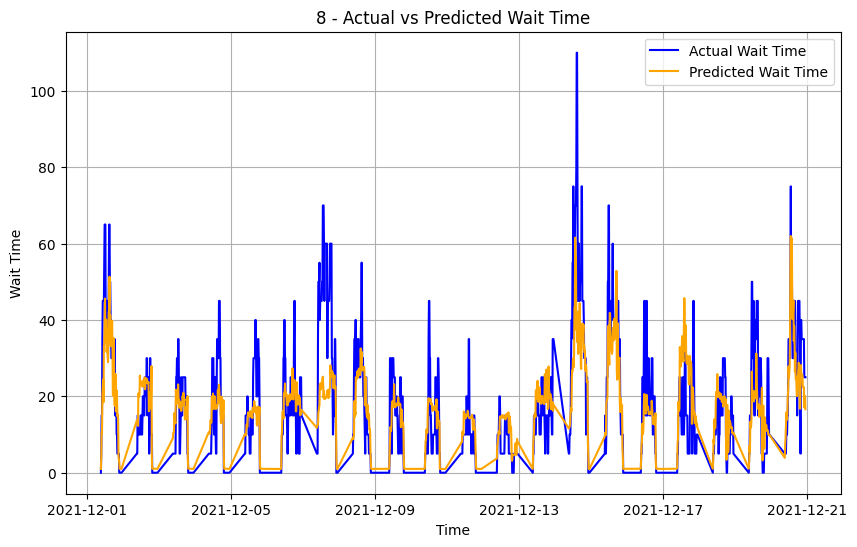

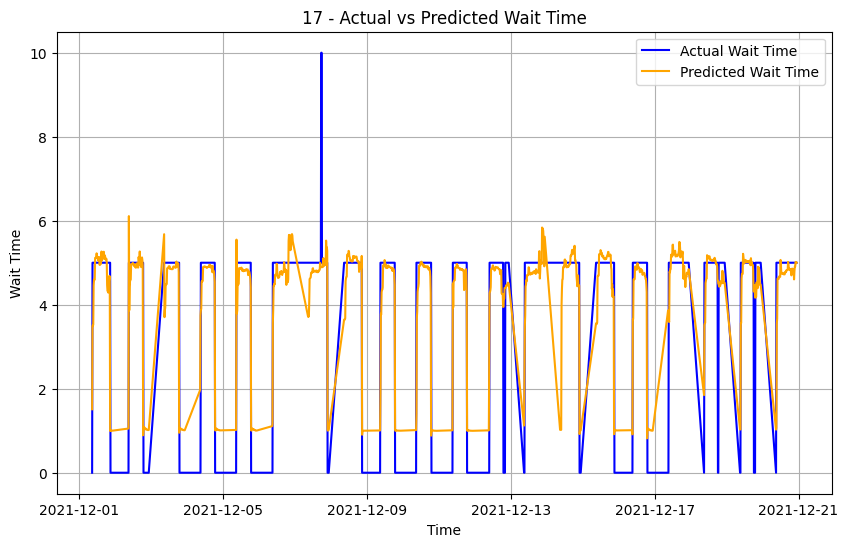

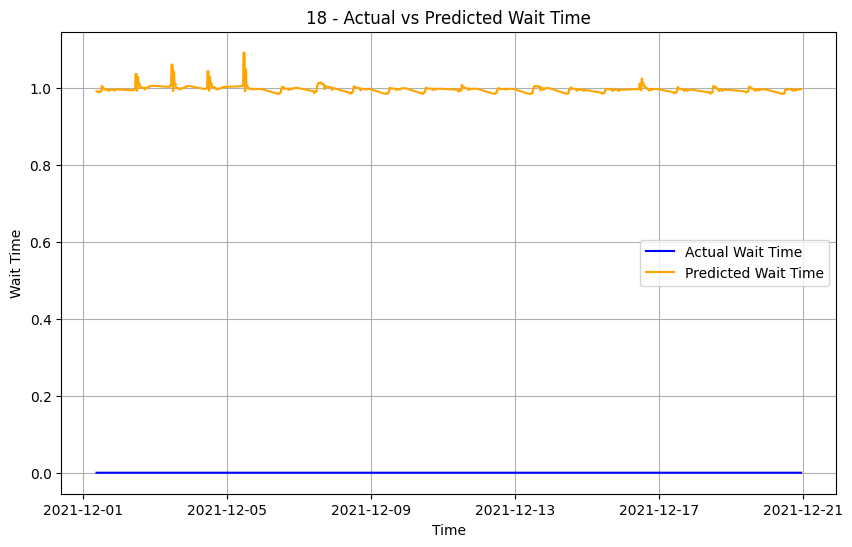

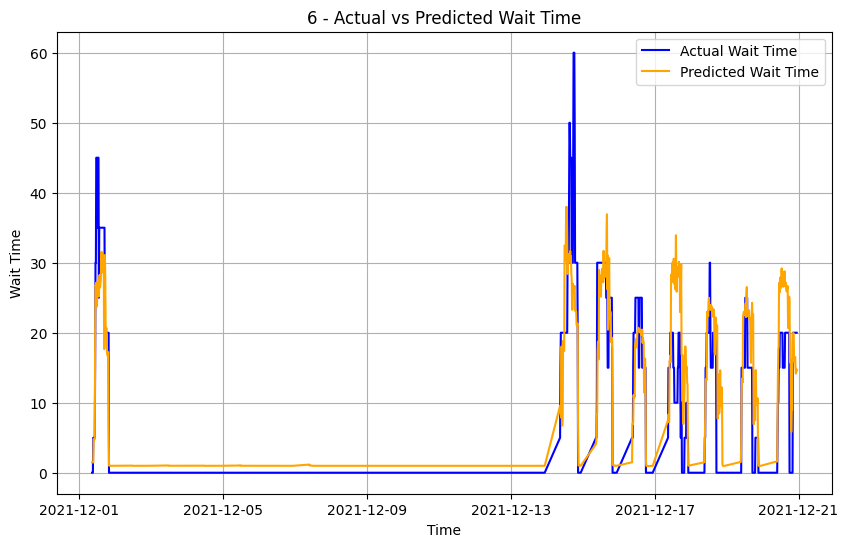

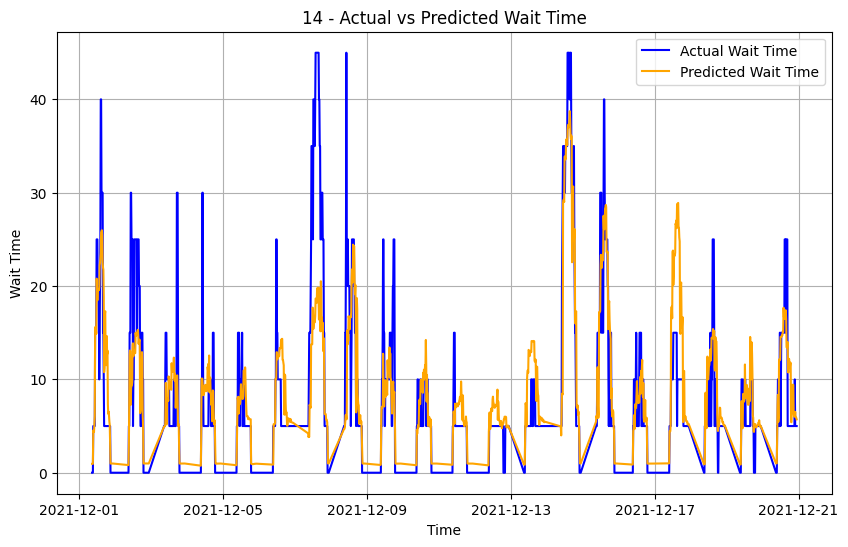

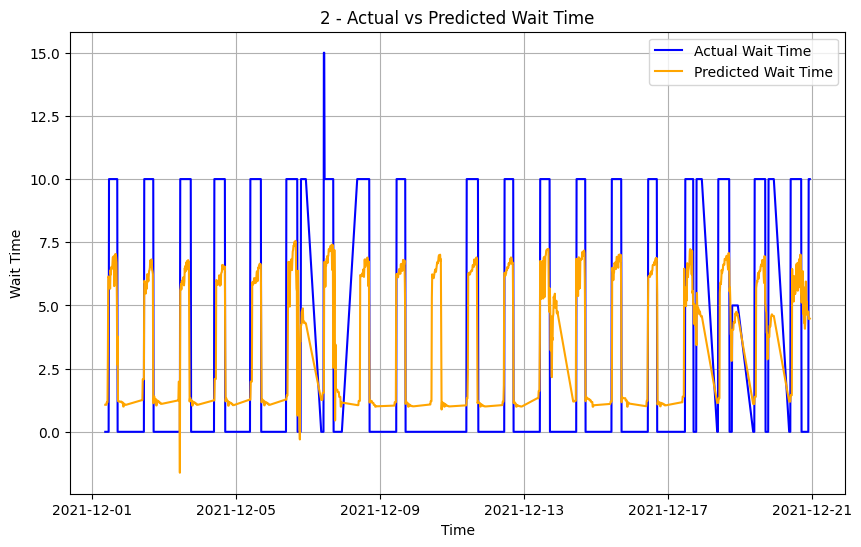

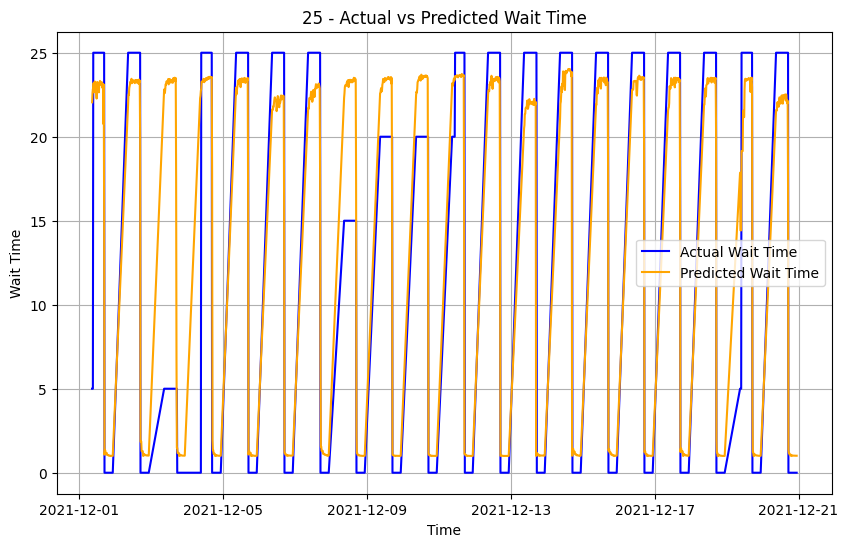

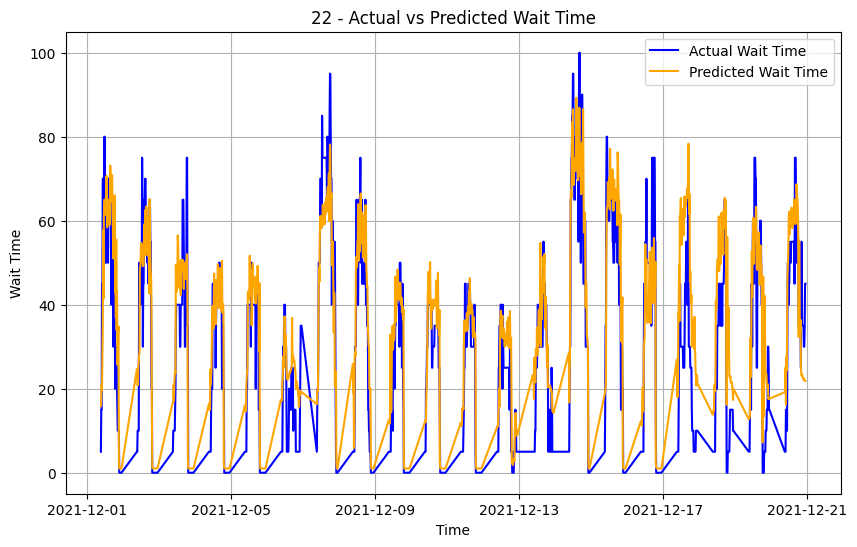

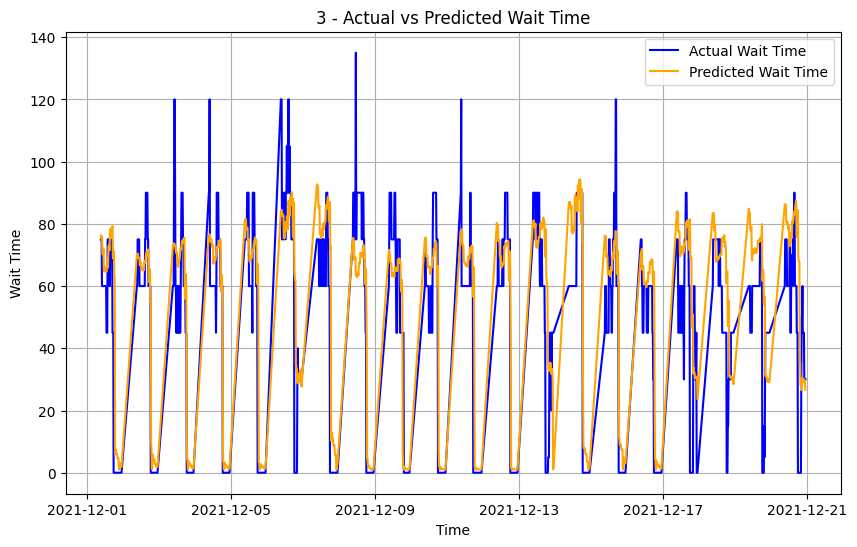

In [49]:
#Visualisation of the model on the test data 
y_pred = model.predict(X_test_reshaped)
results_df = pd.DataFrame({
    'Attraction': test_data['ENTITY_DESCRIPTION_SHORT'],  # Access the correct DataFrame with the column
    'Actual_Wait_Time': y_test,
    'Predicted_Wait_Time': y_pred.flatten()
})

# Group by attraction and find the max wait time (if needed)
max_wait_times = results_df.groupby('Attraction').max()

# Display the max wait times for each attraction
print(max_wait_times)

# Visualize actual vs predicted wait time for each attraction
attractions = results_df['Attraction'].unique()

# Loop through each unique attraction to plot
for attraction in attractions:
    # Filter data for the current attraction
    attraction_data = results_df[results_df['Attraction'] == attraction]
    
    # Plot the actual vs predicted values for this attraction
    plt.figure(figsize=(10, 6))
    plt.plot(attraction_data.index, attraction_data['Actual_Wait_Time'], label='Actual Wait Time', color='blue')
    plt.plot(attraction_data.index, attraction_data['Predicted_Wait_Time'], label='Predicted Wait Time', color='orange')
    plt.title(f'{attraction} - Actual vs Predicted Wait Time')
    plt.xlabel('Time')  # Or use any meaningful x-axis label based on the data
    plt.ylabel('Wait Time')
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
#Predicting and evalution of model on the same timeframe as XGBoost to compare the results
predict_start_date = "2021-12-23"  # Define your prediction start date
predict_end_date = "2021-12-29"    # Define your prediction end date

predict_data_1w = data.merged[(data.merged["WORK_DATE"] >= predict_start_date) & (data.merged["WORK_DATE"] <= predict_end_date)]
X_predict = predict_data_1w.drop(columns=[target] + non_numeric_columns).values
X_predict_reshaped = X_predict.reshape(X_predict.shape[0], timesteps, X_predict.shape[1])
y_test = predict_data_1w[target].values
y_pred = model.predict(X_predict_reshaped)

# Assuming y_test, y_pred, and the original DataFrame 'X_train' (which has 'ENTITY_DESCRIPTION_SHORT') are already defined
# Ensure you access the correct DataFrame with 'ENTITY_DESCRIPTION_SHORT' column
results_df = pd.DataFrame({
    'Attraction': predict_data_1w['ENTITY_DESCRIPTION_SHORT'],  # Access the correct DataFrame with the column
    'Actual_Wait_Time': y_test,
    'Predicted_Wait_Time': y_pred.flatten()
})

# Group by attraction and find the max wait time (if needed)
max_wait_times = results_df.groupby('Attraction').max()

# Display the max wait times for each attraction
print(max_wait_times)

# Visualize actual vs predicted wait time for each attraction
attractions = results_df['Attraction'].unique()

# Loop through each unique attraction to plot
for attraction in attractions:
    # Filter data for the current attraction
    attraction_data = results_df[results_df['Attraction'] == attraction]
    
    # Plot the actual vs predicted values for this attraction
    plt.figure(figsize=(10, 6))
    plt.plot(attraction_data.index, attraction_data['Actual_Wait_Time'], label='Actual Wait Time', color='blue')
    plt.plot(attraction_data.index, attraction_data['Predicted_Wait_Time'], label='Predicted Wait Time', color='orange')
    plt.title(f'{attraction} - Actual vs Predicted Wait Time')
    plt.xlabel('Time')  # Or use any meaningful x-axis label based on the data
    plt.ylabel('Wait Time')
    plt.legend()
    plt.grid(True)
    plt.show()

In [89]:
#Predicting and evalution of model on the same timeframe as XGBoost to compare the results
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Calculate MAE
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error (MAE): {mae:.2f}')

# Calculate MSE
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error (MSE): {mse:.2f}')

# Calculate RMSE
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')

# Calculate R-squared (R2 Score) for accuracy
r2 = r2_score(y_test, y_pred)
print(f'R-squared (R²) Score: {r2:.2f}')


Mean Absolute Error (MAE): 6.30
Mean Squared Error (MSE): 125.60
Root Mean Squared Error (RMSE): 11.21
R-squared (R²) Score: 0.83


In [ ]:
from endless_line.data_utils.weather_forecast import WeatherForecast
from endless_line.models.model_utils import save_model, load_model
from endless_line.models.attendance_model import train_attendance_model, predict_attendance

#Get Weather Forecast for next week from the WeatherForecast class that uses API to get the data
forecast = WeatherForecast()
forecast_data = forecast.get_forecast()
model_attendance = train_attendance_model(data, pre_covid=False, save=True)

# Predict the attendance of the next 5 days
forecast_result = predict_attendance(model_attendance, days_to_predict=5)


In [140]:
print(forecast_result)

          ds          yhat
0 2025-02-14  43393.371085
1 2025-02-15  32025.332987
2 2025-02-16  28906.360058
3 2025-02-17  42913.526120
4 2025-02-18  42738.416614


In [160]:
##Creating a proxy for all the data needed by the model fro the next 5 days from the 2022 data
# Define the data for the next 5 days using 2nd friday of February 2022 as the start date same as tomorrow 
predict_start_date = "2022-02-11"  # Define your prediction start date
predict_end_date = "2022-02-15"    # Define your prediction end date

predict_data_1w = data.merged[(data.merged["WORK_DATE"] >= predict_start_date) & (data.merged["WORK_DATE"] <= predict_end_date)]
#Change the date to 2025 to match the model
predict_data_1w['WORK_DATE'] = predict_data_1w['WORK_DATE'] + pd.DateOffset(years=3, days=3)

predict_data_1w = predict_data_1w.reset_index()  # Reset index to make DEB_TIME a column

# Adjust DEB_TIME to match the year in WORK_DATE
predict_data_1w['DEB_TIME'] = predict_data_1w.apply(
    lambda row: row['DEB_TIME'].replace(year=row['WORK_DATE'].year, day=row['WORK_DATE'].day), axis=1
)


prediction = predict_data_1w.drop(columns= ['temp', 'feels_like',
       'pressure', 'wind_speed', 'clouds_all', 'weather_description_encoded',
       'weather_main_encoded','attendance', 'WAIT_TIME_MAX','day',])
prediction["DEB_TIME_2"] = pd.to_datetime(prediction["WORK_DATE"]) + pd.to_timedelta(prediction["DEB_TIME_HOUR"], unit="h")
forecast_data["dt_iso"] = pd.to_datetime(forecast_data["dt_iso"])

# Merge on matching datetime values
prediction = prediction.merge(forecast_data, left_on="DEB_TIME_2", right_on="dt_iso", how="left")

prediction.drop(columns=["dt_iso", "DEB_TIME_2"], inplace=True)
prediction = prediction.sort_values('DEB_TIME').bfill()


# Merge forecast_result to update attendance
prediction = prediction.merge(forecast_result, left_on='WORK_DATE', right_on='ds', how='left').drop(columns='ds')

# Rename `yhat` to `attendance` (coming from forecast_result)
prediction = prediction.rename(columns={'yhat': 'attendance'})

# Recompute 'day' and 'day_of_week' based on the updated WORK_DATE
prediction['day'] = prediction['WORK_DATE'].dt.day
prediction['day_of_week'] = prediction['WORK_DATE'].dt.dayofweek
# Set DEB_TIME as the index and sort by it
prediction.set_index('DEB_TIME', inplace=True)
prediction.sort_index(inplace=True)

# Confirm the changes by printing the first few rows
print(prediction.head())




                     WORK_DATE  DEB_TIME_HOUR  ENTITY_DESCRIPTION_SHORT  \
DEB_TIME                                                                  
2025-02-14 09:00:00 2025-02-14              9                       NaN   
2025-02-14 09:00:00 2025-02-14              9                       NaN   
2025-02-14 09:00:00 2025-02-14              9                       NaN   
2025-02-14 09:00:00 2025-02-14              9                       NaN   
2025-02-14 09:00:00 2025-02-14              9                       NaN   

                     NB_UNITS  GUEST_CARRIED  CAPACITY  ADJUST_CAPACITY  \
DEB_TIME                                                                  
2025-02-14 09:00:00  0.000000       0.000000  0.000000         0.000000   
2025-02-14 09:00:00  0.036923       0.000000  0.232033         0.092835   
2025-02-14 09:00:00  0.023077       0.000000  0.000000         0.000000   
2025-02-14 09:00:00  0.138462       0.013294  0.134788         0.134788   
2025-02-14 09:00:00  0.0

/var/folders/rk/8c_5m9t103bc7prmfk4b39c00000gn/T/ipykernel_6588/3711569622.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict_data_1w['WORK_DATE'] = predict_data_1w['WORK_DATE'] + pd.DateOffset(years=3, days=3)


In [161]:
print(prediction.dtypes)

WORK_DATE                   datetime64[ns]
DEB_TIME_HOUR                        int64
ENTITY_DESCRIPTION_SHORT           float64
NB_UNITS                           float64
GUEST_CARRIED                      float64
CAPACITY                           float64
ADJUST_CAPACITY                    float64
OPEN_TIME                            int64
UP_TIME                            float64
DOWNTIME                           float64
NB_MAX_UNIT                        float64
show_or_parade                       int64
Num_parade                         float64
Bumper Cars                        float64
Bungee Jump                        float64
Circus Train                       float64
Crazy Dance                        float64
Dizzy Dropper                      float64
Drop Tower                         float64
Flying Coaster                     float64
Free Fall                          float64
Giant Wheel                        float64
Giga Coaster                       float64
Go-Karts   

In [ ]:
## CREATING A FILE FOR THE DASHBOARD THAT HAS THE PREDICTIONS FOR THE NEXT 5 DAYS along with the actual data for the last month
# 
X_predict = prediction.drop(columns = ['WORK_DATE']).values
X_predict_reshaped = X_predict.reshape(X_predict.shape[0], timesteps, X_predict.shape[1])
y_pred = model.predict(X_predict_reshaped)

results_df = pd.DataFrame({
    'Attraction': prediction['ENTITY_DESCRIPTION_SHORT'],  # Access the correct DataFrame with the column
    'Actual_Wait_Time': y_test,
    'Predicted_Wait_Time': y_pred.flatten()
})
max_wait_times = results_df.groupby('Attraction').max()

# Display the max wait times for each attraction
print(max_wait_times)

# Visualize actual vs predicted wait time for each attraction
attractions = results_df['Attraction'].unique()

# Loop through each unique attraction to plot
for attraction in attractions:
    # Filter data for the current attraction
    attraction_data = results_df[results_df['Attraction'] == attraction]
    
    # Plot the actual vs predicted values for this attraction
    plt.figure(figsize=(10, 6))
    plt.plot(attraction_data.index, attraction_data['Actual_Wait_Time'], label='Actual Wait Time', color='blue')
    plt.plot(attraction_data.index, attraction_data['Predicted_Wait_Time'], label='Predicted Wait Time', color='orange')
    plt.title(f'{attraction} - Actual vs Predicted Wait Time')
    plt.xlabel('Time')  # Or use any meaningful x-axis label based on the data
    plt.ylabel('Wait Time')
    plt.legend()
    plt.grid(True)
    plt.show()

In [60]:

entity_mapping_reverse = {
    1: 'Rapids Ride', 2: 'Oz Theatre',
    3: 'Spiral Slide',
    4: 'Himalaya Ride', 
    5: 'Free Fall',
    6: 'Water Ride',
    7: 'Merry Go Round',
    8: 'Spinning Coaster',
    9: 'Go-Karts',
    10: 'Bumper Cars',
    11: 'Kiddie Coaster',
    12: 'Bungee Jump',
    13: 'Roller Coaster',
    14: 'Flying Coaster',
    15: 'Haunted House',
    16: 'Giga Coaster',
    17: 'Crazy Dance',
    18: 'Inverted Coaster',
    19: 'Drop Tower',
    20: 'Circus Train',
    21: 'Zipline',
    22: 'Giant Wheel',
    23: 'Swing Ride',
    24: 'Dizzy Dropper',
    25: 'Superman Ride'
}

# Map ENTITY_DESCRIPTION_SHORT to numeric values
predict_data_2m["ENTITY_DESCRIPTION_SHORT"] = predict_data_2m["ENTITY_DESCRIPTION_SHORT"].map(entity_mapping_reverse)

results_df = pd.DataFrame({
    'Attraction': predict_data_2m['ENTITY_DESCRIPTION_SHORT'],  # Access the correct DataFrame with the column
    'Predicted_Wait_Time': y_pred.flatten()
})

/var/folders/rk/8c_5m9t103bc7prmfk4b39c00000gn/T/ipykernel_6588/2357301499.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict_data_2m["ENTITY_DESCRIPTION_SHORT"] = predict_data_2m["ENTITY_DESCRIPTION_SHORT"].map(entity_mapping_reverse)


In [62]:
print(results_df)

                 DEB_TIME     Attraction  Predicted_Wait_Time
0     2022-01-01 09:00:00    Bungee Jump             7.237847
1     2022-01-01 09:00:00  Dizzy Dropper             6.083707
2     2022-01-01 09:00:00  Superman Ride            24.247864
3     2022-01-01 09:00:00      Free Fall             1.269165
4     2022-01-01 09:00:00    Giant Wheel            16.584887
...                   ...            ...                  ...
83995 2022-03-01 22:45:00       Go-Karts             1.010166
83996 2022-03-01 22:45:00     Drop Tower             1.023864
83997 2022-03-01 22:45:00  Dizzy Dropper             0.987993
83998 2022-03-01 22:45:00   Giga Coaster             1.008504
83999 2022-03-01 22:45:00      Free Fall             1.008567

[84000 rows x 3 columns]


In [91]:
entity_mapping_reverse = {
    1: 'Rapids Ride', 2: 'Oz Theatre',
    3: 'Spiral Slide',
    4: 'Himalaya Ride', 
    5: 'Free Fall',
    6: 'Water Ride',
    7: 'Merry Go Round',
    8: 'Spinning Coaster',
    9: 'Go-Karts',
    10: 'Bumper Cars',
    11: 'Kiddie Coaster',
    12: 'Bungee Jump',
    13: 'Roller Coaster',
    14: 'Flying Coaster',
    15: 'Haunted House',
    16: 'Giga Coaster',
    17: 'Crazy Dance',
    18: 'Inverted Coaster',
    19: 'Drop Tower',
    20: 'Circus Train',
    21: 'Zipline',
    22: 'Giant Wheel',
    23: 'Swing Ride',
    24: 'Dizzy Dropper',
    25: 'Superman Ride'
}

# Map ENTITY_DESCRIPTION_SHORT to numeric values
predict_data_2m["ENTITY_DESCRIPTION_SHORT"] = predict_data_2m["ENTITY_DESCRIPTION_SHORT"].map(entity_mapping_reverse)

results_df = pd.DataFrame({
    'Attraction': predict_data_2m['ENTITY_DESCRIPTION_SHORT'],  # Access the correct DataFrame with the column
    'Predicted_Wait_Time': y_pred.flatten()
})

/var/folders/rk/8c_5m9t103bc7prmfk4b39c00000gn/T/ipykernel_6588/74399085.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict_data_2m["ENTITY_DESCRIPTION_SHORT"] = predict_data_2m["ENTITY_DESCRIPTION_SHORT"].map(entity_mapping_reverse)


In [ ]:


predict_data_1m = data.merged[(data.merged["WORK_DATE"] >= predict_start_date) & (data.merged["WORK_DATE"] <= predict_end_date)]
entity_mapping_reverse = {
    1: 'Rapids Ride', 2: 'Oz Theatre',
    3: 'Spiral Slide',
    4: 'Himalaya Ride', 
    5: 'Free Fall',
    6: 'Water Ride',
    7: 'Merry Go Round',
    8: 'Spinning Coaster',
    9: 'Go-Karts',
    10: 'Bumper Cars',
    11: 'Kiddie Coaster',
    12: 'Bungee Jump',
    13: 'Roller Coaster',
    14: 'Flying Coaster',
    15: 'Haunted House',
    16: 'Giga Coaster',
    17: 'Crazy Dance',
    18: 'Inverted Coaster',
    19: 'Drop Tower',
    20: 'Circus Train',
    21: 'Zipline',
    22: 'Giant Wheel',
    23: 'Swing Ride',
    24: 'Dizzy Dropper',
    25: 'Superman Ride'
}

# Map ENTITY_DESCRIPTION_SHORT to numeric values
predict_data_1m["ENTITY_DESCRIPTION_SHORT"] = predict_data_1m["ENTITY_DESCRIPTION_SHORT"].map(entity_mapping_reverse)
y_test = predict_data_1m[target].values

results_df_2 = pd.DataFrame({
    'Attraction': predict_data_1m['ENTITY_DESCRIPTION_SHORT'],  # Access the correct DataFrame with the column
    'Wait_Time': y_test.flatten()
})

/var/folders/rk/8c_5m9t103bc7prmfk4b39c00000gn/T/ipykernel_6588/3299379535.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict_data_1m["ENTITY_DESCRIPTION_SHORT"] = predict_data_1m["ENTITY_DESCRIPTION_SHORT"].map(entity_mapping_reverse)


In [ ]:
# Ensure the index is reset to include DEB_TIME in the DataFrame
results_df = results_df.reset_index()  # This resets any index back to a column
results_df_2 = results_df_2.reset_index()
# Use DEB_TIME as the index for pivoting
predicted_pivot = results_df.pivot(index='DEB_TIME', columns='Attraction', values='Predicted_Wait_Time')
actual_pivot = results_df_2.pivot(index='DEB_TIME', columns='Attraction', values='Wait_Time')



In [94]:
import pandas as pd

# Add a source column to distinguish between actual and predicted data
results_df['Source'] = 1  # 1 for predicted data
results_df_2['Source'] = 0  # 0 for actual data

# Rename 'Wait_Time' to match 'Predicted_Wait_Time' for uniformity before concatenation
results_df_2 = results_df_2.rename(columns={'Wait_Time': 'Predicted_Wait_Time'})

# Ensure both dataframes have the same column names
common_columns = ['DEB_TIME', 'Attraction', 'Predicted_Wait_Time', 'Source']
results_df = results_df[common_columns]
results_df_2 = results_df_2[common_columns]

# Concatenate both DataFrames
combined_df = pd.concat([results_df, results_df_2])

# Sort by DEB_TIME and Attraction (optional, for better readability)
combined_df = combined_df.sort_values(by=['DEB_TIME', 'Attraction'])

# Reset index
combined_df = combined_df.reset_index(drop=True)

# Display the combined DataFrame
print(combined_df.head())


             DEB_TIME     Attraction  Predicted_Wait_Time  Source
0 2022-01-01 09:00:00    Bumper Cars                  5.0       0
1 2022-01-01 09:00:00    Bungee Jump                  5.0       0
2 2022-01-01 09:00:00   Circus Train                  5.0       0
3 2022-01-01 09:00:00    Crazy Dance                  5.0       0
4 2022-01-01 09:00:00  Dizzy Dropper                  5.0       0


In [95]:
predicted_pivot = results_df.pivot(index='DEB_TIME', columns='Attraction', values='Predicted_Wait_Time')

In [96]:
import pandas as pd

# Add a source column: 'Predicted' for model predictions, 'Actual' for real data
results_df['Source'] = '1'
results_df_2['Source'] = '0'

# Rename 'Wait_Time' in actual data to match 'Predicted_Wait_Time' column
results_df_2 = results_df_2.rename(columns={'Wait_Time': 'Predicted_Wait_Time'})

# Select relevant columns to ensure consistency
common_columns = ['DEB_TIME', 'Attraction', 'Predicted_Wait_Time', 'Source']
results_df = results_df[common_columns]
results_df_2 = results_df_2[common_columns]

# Concatenate both DataFrames
combined_df = pd.concat([results_df, results_df_2])

# Pivot without duplicating the "Source" label under each attraction
pivot_df = combined_df.pivot(index=['DEB_TIME', 'Source'], columns='Attraction', values='Predicted_Wait_Time')

# Reset index so that "Source" appears as a single column rather than part of the index
pivot_df = pivot_df.reset_index()

# Display the pivoted DataFrame
print(pivot_df.head())


Attraction            DEB_TIME Source  Bumper Cars  Bungee Jump  Circus Train  \
0          2022-01-01 09:00:00      0          5.0          5.0           5.0   
1          2022-01-01 09:15:00      0          5.0          5.0           5.0   
2          2022-01-01 09:30:00      0          5.0          5.0           5.0   
3          2022-01-01 09:45:00      0          5.0          5.0           5.0   
4          2022-01-01 10:00:00      0          5.0         10.0           5.0   

Attraction  Crazy Dance  Dizzy Dropper  Drop Tower  Flying Coaster  Free Fall  \
0                   5.0            5.0         5.0             5.0        0.0   
1                   5.0            5.0         5.0             5.0        0.0   
2                   5.0            5.0        15.0             5.0        0.0   
3                   5.0            5.0        15.0             5.0        5.0   
4                   5.0            5.0        15.0             5.0       70.0   

Attraction  ...  Merry Go 

In [97]:
# Save the final DataFrame to a CSV file
import os

path = os.path.join('..', 'data', 'lstm_attraction_wait_times.csv')

pivot_df.to_csv(path, index=False)
